In [53]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [15]:
# LSTM_Live 폴더의 모든 CSV 파일 병합
def LSTM_Live_Merge(folder_path):
    
    csv_files = []

    # 하위 폴더까지 탐색
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                
                # CSV 불러오기
                df = pd.read_csv(csv_path)
                csv_files.append(df)

    # 모든 CSV 파일 병합
    if csv_files:
        combined_df = pd.concat(csv_files, ignore_index=True)
        print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
        return combined_df
    else:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()


In [16]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# 폴더 내 CSV 파일 병합
def LSTM_Capture_Merge(folder_path, sequence):
    
    csv_files = []

    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)
        
        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀
        
        if file_count % sequence != 0:
            print(f"[제외] {root}: CSV 파일 수 {file_count}개는 {sequence}의 배수가 아닙니다.")
            continue  # sequence의 배수가 아니면 병합 제외

        for file in sorted_files:
            csv_path = os.path.join(root, file)
            csv_files.append(csv_path)

    if not csv_files:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()
    
    # CSV 파일 병합 (float_precision 추가)
    dataframes = [pd.read_csv(file, float_precision='round_trip') for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
    return combined_df

In [17]:
# 데이터 시퀀스별로 변환
def reshape_to_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])  # 시퀀스의 마지막 레이블 사용
    return np.array(sequences), np.array(sequence_labels)

In [18]:
# 데이터 불러오기 및 병합
folder_path = './Data'  # 데이터 폴더 경로
df_live = LSTM_Live_Merge(folder_path + '/LSTM_Live') # LSTM_Live 폴더 병합
df_capture = LSTM_Capture_Merge(folder_path + '/LSTM_Capture', sequence=3) # LSTM_Capture 폴더 병합
df= pd.concat([df_live, df_capture], ignore_index=True) # 전체 폴더 병합

병합할 CSV 파일이 없습니다.
총 3624개의 CSV 파일을 병합했습니다. 데이터 크기: (3624, 35)


In [19]:
# 데이터프레임 확인
df

,kp0_x,kp0_y,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,kp4_y,...,kp12_y,kp13_x,kp13_y,kp14_x,kp14_y,kp15_x,kp15_y,kp16_x,kp16_y,action_class
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186.562317,97.413239,...,189.882309,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.938446,107.939316,...,202.759811,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.495056,108.826836,...,202.612686,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,193.227295,108.078430,...,198.819366,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,187.580933,106.747070,...,199.130951,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,201.846695,149.767776,205.054123,147.687546,200.026764,147.590378,211.117142,148.287674,198.476395,147.630188,...,200.290024,181.882629,235.131973,176.619385,230.295471,0.0,0.0,0.0,0.0,4
3620,207.829071,148.943146,210.760345,146.891525,205.216812,146.662842,215.577881,148.229828,201.599960,147.383255,...,204.139755,190.339355,239.447052,186.464508,237.257660,0.0,0.0,0.0,0.0,4
3621,198.767273,151.729233,202.542679,148.697769,198.372147,148.876968,212.771347,149.071030,0.000000,0.000000,...,211.829971,189.423233,250.263626,174.982971,243.225876,0.0,0.0,0.0,0.0,4
3622,195.412125,147.921295,199.790573,144.432999,195.537384,145.576797,210.806320,147.053711,0.000000,0.000000,...,220.371140,184.283051,256.564087,0.000000,0.000000,0.0,0.0,0.0,0.0,4


In [20]:
# X, y 분리
X = df.iloc[:, :-1].values # 키포인트
y = df.iloc[:, -1].values # 클래스

In [21]:
# 레이블 원-핫 인코딩
y = to_categorical(y)

In [22]:
# 데이터 시퀀스 길이 지정
seq_length = 3  # 시퀀스 길이

# 데이터를 시퀀스 형태로 변환
X_seq, y_seq = reshape_to_sequences(X, y, seq_length)

In [23]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [61]:
# LSTM 모델 정의
model = Sequential([
    LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
    ])

In [62]:
 # 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20, mode = 'auto', restore_best_weights=True)
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32).history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=es).history

Epoch 1/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7085 - loss: 0.9952 - val_accuracy: 0.8621 - val_loss: 0.4918
Epoch 2/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8199 - loss: 0.5998 - val_accuracy: 0.8621 - val_loss: 0.4632
Epoch 3/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8336 - loss: 0.5067 - val_accuracy: 0.8648 - val_loss: 0.4179
Epoch 4/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8375 - loss: 0.4840 - val_accuracy: 0.8676 - val_loss: 0.4232
Epoch 5/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8406 - loss: 0.4898 - val_accuracy: 0.8676 - val_loss: 0.4250
Epoch 6/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8305 - loss: 0.4860 - val_accuracy: 0.8676 - val_loss: 0.4061
Epoch 7/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8422 - loss: 0.4729 - val_accuracy: 0.8676 - val_loss: 0.3955
Epoch 8/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8392 - loss: 0.4631 - val_accuracy: 0.8662

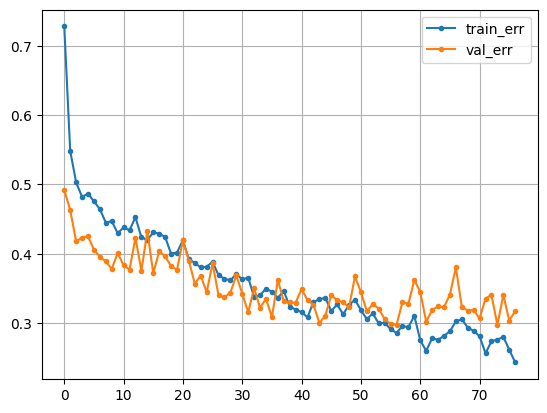

In [63]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [64]:
# 모델 저장
output_model = './Model/LSTM.h5'
model.save(output_model)

In [67]:
# 학습된 모델 평가
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 데이터 정확도: {accuracy * 100:.2f}%")

검증 데이터 정확도: 89.38%
